O PySentimiento é uma das bibliotecas mais interessantes atualmente para análise de sentimentos e emoções com suporte a vários idiomas, incluindo português.

Ele foi criado sobre modelos BERT e RoBERTa já pré-treinados e afinados (fine-tuned) para tarefas de NLP social, como:
✅ Análise de sentimentos
✅ Análise de emoções
✅ Detecção de ódio
✅ Detecção de ironia

| Recurso                | Descrição                              |
| ---------------------- | -------------------------------------- |
| **Idiomas suportados** | en, es, it, pt, fr, ca, eu, gl         |
| **Tarefas**            | Sentiment, Emotion, Hate Speech, Irony |
| **Base**               | Modelos BERT/RoBERTa fine-tuned        |
| **Instalação**         | `pip install pysentimiento`            |


In [4]:
import pandas as pd

import emoji
from pysentimiento import create_analyzer

from joblib import Parallel, delayed


import spacy

import vader
import textblob

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import plotly.graph_objects as go

In [14]:
comentarios = pd.read_csv("comentarios.csv")
comentarios = comentarios[["date", "app_version", "score", "system", "app", "content"]]
comentarios.head()

,date,app_version,score,system,app,content
0,2025-05-27 18:54:37,18.7.0,5,Android,Claro,legal 😎
1,2025-05-27 18:10:04,18.6.0,5,Android,Claro,Encontro facilidade por aqui 👏
2,2025-05-27 17:49:18,18.7.0,5,Android,Claro,muito bom
3,2025-05-27 17:46:20,NaN,1,Android,Claro,ruim que vc deseja não tem informações
4,2025-05-27 17:20:22,18.7.0,5,Android,Claro,melhor do mundo


In [16]:
#Tenho 50k de comentários por app, mas vou usar apenas 5k
comentarios_claro = comentarios[comentarios["app"] == "Claro"][:5000]
comentarios_tim = comentarios[comentarios["app"] == "TIM"][:5000]
comentarios_vivo = comentarios[comentarios["app"] == "Vivo"][:5000]

**Processamento dos Emojis**

In [17]:
def remover_emojis(texto):
    return emoji.demojize(texto, language='pt')

comentarios_claro["comentario_sem_emoji"] = comentarios_claro["content"].apply(remover_emojis)
comentarios_tim["comentario_sem_emoji"] = comentarios_tim["content"].apply(remover_emojis)
comentarios_vivo["comentario_sem_emoji"] = comentarios_vivo["content"].apply(remover_emojis)


|Tipo de Análise | Informativo |
|----------------|-------------|
| emotion        | aaaa        |
| irony          | aaaa        |
| hate_speech    | aaaa        |
| sentiment      | aaaa        |

# Análise de Sentimento

**pysentimiento**
- Biblioteca que oferece modelos baseados em BERT, fine-tunados para emoções e sentimento em português.
- Usa modelos robustos, prontos para uso.

✅ Pontos positivos:
Muito mais preciso.

Entende contexto, ironia, gírias e até alguns emojis.

Modelos modernos.

❌ Pontos negativos:
Mais pesado.

Pode exigir mais tempo de execução.

Não personalizável facilmente.

## Funções

In [56]:
#Função para realizar todas as análises
analyzers = {
    "irony": create_analyzer(task="irony", lang="pt"),
    "hate_speech": create_analyzer(task="hate_speech", lang="pt"),
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt")
}

def analisar_sentimento_todos(texto, analyzers=analyzers):

    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        # Ajuste seguro do output
        if isinstance(resultado.output, list):
            saida = resultado.output[0] if resultado.output else None
        else:
            saida = resultado.output

        dados[f"{tipo}_output"] = saida

        for k, v in resultado.probas.items():
            dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


In [73]:
#TESTE
# Criando os analyzers
analyzers = {
    "irony": create_analyzer(task="irony", lang="pt"),
    "hate_speech": create_analyzer(task="hate_speech", lang="pt"),
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt")
}

# Grupos para emoções resumidas
grupos_emocoes = {
    "alegria": ["admiration", "amusement", "approval", "excitement",
        "gratitude", "joy", "love", "optimism", "pride"],
    "tristeza": ["disappointment", "remorse", "sadness"],
    "raiva": ["anger", "annoyance", "disapproval", "disgust"],
    "medo": ["fear", "nervousness", "embarrassment"],
    "surpresa": ["surprise", "realization"],
    "confianca_interesse": ["curiosity", "desire", "caring"],
    "confusao": ["confusion"],
    "neutro": ["neutral", None]
}



def analisar_sentimento_todos(texto, analyzers=analyzers):

    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        # Ajuste seguro do output
        if isinstance(resultado.output, list):
            saida = resultado.output[0] if resultado.output else None
        else:
            saida = resultado.output

        dados[f"{tipo}_output"] = saida

        if tipo == "emotion":
            # Pós-processamento: agregando emoções
            for grupo, emocoes in grupos_emocoes.items():
                soma = sum(resultado.probas.get(e, 0) for e in emocoes)
                dados[f"{tipo}_{grupo}"] = soma
        else:
            # Para outras tasks, mantém probas originais
            for k, v in resultado.probas.items():
                dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


In [76]:
analyzers = {
    "irony": create_analyzer(task="irony", lang="pt"),
    "hate_speech": create_analyzer(task="hate_speech", lang="pt"),
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt")
}

# Grupos para emoções resumidas
grupos_emocoes = {
    "alegria": ["admiration", "amusement", "approval", "excitement",
                "gratitude", "joy", "love", "optimism", "pride"],
    "tristeza": ["disappointment", "remorse", "sadness"],
    "raiva": ["anger", "annoyance", "disapproval", "disgust"],
    "medo": ["fear", "nervousness", "embarrassment"],
    "surpresa": ["surprise", "realization"],
    "confianca_interesse": ["curiosity", "desire", "caring"],
    "confusao": ["confusion"],
    "neutro": ["neutral", None]
}

def analisar_sentimento_todos(texto, analyzers=analyzers):
    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        # Ajuste seguro do output
        if isinstance(resultado.output, list):
            saida = resultado.output[0] if resultado.output else None
        else:
            saida = resultado.output

        # Para emoção, substituir output pela categoria agregada
        if tipo == "emotion":
            # Pós-processamento: agregando emoções
            grupo_probs = {}
            for grupo, emocoes in grupos_emocoes.items():
                soma = sum(resultado.probas.get(e, 0) for e in emocoes)
                dados[f"{tipo}_{grupo}"] = soma
                grupo_probs[grupo] = soma
            
            # Encontrar o grupo com maior probabilidade
            if grupo_probs:
                grupo_principal = max(grupo_probs, key=grupo_probs.get)
            else:
                grupo_principal = None

            dados[f"{tipo}_output"] = grupo_principal
        else:
            # Mantém output original
            dados[f"{tipo}_output"] = saida
            # Mantém probas originais
            for k, v in resultado.probas.items():
                dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


In [7]:
#Função para realizar apenas uma análise
def analisar_sentimento(texto):
    resultado = analyzer.predict(texto)

    if resultado.output:
        saida = resultado.output[0]
    else:
        saida = None

    dados = {'output':  saida}

    for emocao, prob in resultado.probas.items():
        dados[emocao] = prob

    return pd.Series(dados)

## Análises

In [77]:
resultados = comentarios_claro["comentario_sem_emoji"].apply(analisar_sentimento_todos)
df_claro2 = pd.concat([comentarios_claro, resultados], axis=1)
df_claro2.head()


,date,app_version,score,system,app,content,comentario_sem_emoji,irony_output,irony_not ironic,irony_ironic,...,sentiment_POS,emotion_alegria,emotion_tristeza,emotion_raiva,emotion_medo,emotion_surpresa,emotion_confianca_interesse,emotion_confusao,emotion_neutro,emotion_output
0,2025-05-27 18:54:37,18.7.0,5,Android,Claro,legal 😎,legal :rosto_sorridente_com_óculos_escuros:,ironic,0.000037,0.999963,...,0.961111,1.283742,0.002332,0.002309,0.000413,0.002898,0.004247,0.000313,0.015898,alegria
1,2025-05-27 18:10:04,18.6.0,5,Android,Claro,Encontro facilidade por aqui 👏,Encontro facilidade por aqui :mãos_aplaudindo:,ironic,0.000038,0.999962,...,0.961130,0.148274,0.002687,0.005374,0.000407,0.008645,0.004322,0.000552,0.913299,neutro
2,2025-05-27 17:49:18,18.7.0,5,Android,Claro,muito bom,muito bom,ironic,0.000039,0.999961,...,0.993020,1.026943,0.001751,0.002410,0.000696,0.002040,0.002979,0.000661,0.006966,alegria
3,2025-05-27 17:46:20,NaN,1,Android,Claro,ruim que vc deseja não tem informações,ruim que vc deseja não tem informações,ironic,0.000037,0.999963,...,0.016130,0.010556,0.492551,0.410869,0.005484,0.004519,0.004077,0.004247,0.294686,tristeza
4,2025-05-27 17:20:22,18.7.0,5,Android,Claro,melhor do mundo,melhor do mundo,ironic,0.000038,0.999962,...,0.986870,1.035333,0.001484,0.003026,0.000532,0.001318,0.003655,0.000242,0.013483,alegria


In [78]:
resultados = comentarios_tim["comentario_sem_emoji"].apply(analisar_sentimento_todos)
df_tim2 = pd.concat([comentarios_tim, resultados], axis=1)
df_tim2.head()

,date,app_version,score,system,app,content,comentario_sem_emoji,irony_output,irony_not ironic,irony_ironic,...,sentiment_POS,emotion_alegria,emotion_tristeza,emotion_raiva,emotion_medo,emotion_surpresa,emotion_confianca_interesse,emotion_confusao,emotion_neutro,emotion_output
50000,2025-05-27 18:54:19,8.6.0,4,Android,TIM,boa,boa,ironic,0.000040,0.999960,...,0.327882,1.025841,0.001754,0.002995,0.000476,0.001520,0.005665,0.000402,0.029051,alegria
50001,2025-05-27 18:50:55,8.6.0,5,Android,TIM,ótimo,ótimo,ironic,0.000038,0.999962,...,0.987748,1.013204,0.001223,0.002282,0.000558,0.001696,0.002882,0.000630,0.009268,alegria
50002,2025-05-27 18:46:49,8.7.0,5,Android,TIM,"precisa simplificar o site e o aplicativo, col...","precisa simplificar o site e o aplicativo, col...",ironic,0.000060,0.999939,...,0.062640,0.011865,0.001357,0.005398,0.000581,0.002849,0.006411,0.001522,0.991875,neutro
50003,2025-05-27 18:45:21,8.2.0,5,Android,TIM,"Muito boa, parabéns!!","Muito boa, parabéns!!",ironic,0.000037,0.999963,...,0.990093,1.518033,0.001365,0.002874,0.000810,0.005114,0.005551,0.000825,0.007311,alegria
50004,2025-05-27 18:38:02,8.7.0,5,Android,TIM,Tudo okay,Tudo okay,ironic,0.000040,0.999960,...,0.175979,0.028290,0.001109,0.008622,0.000597,0.003663,0.003064,0.001390,0.990481,neutro


In [79]:
resultados = comentarios_vivo["comentario_sem_emoji"].apply(analisar_sentimento_todos)
df_vivo2 = pd.concat([comentarios_vivo, resultados], axis=1)
df_vivo2.head()

,date,app_version,score,system,app,content,comentario_sem_emoji,irony_output,irony_not ironic,irony_ironic,...,sentiment_POS,emotion_alegria,emotion_tristeza,emotion_raiva,emotion_medo,emotion_surpresa,emotion_confianca_interesse,emotion_confusao,emotion_neutro,emotion_output
100000,2025-05-27 18:54:39,25.5.23,5,Android,Vivo,boa,boa,ironic,0.000040,0.999960,...,0.327882,1.025841,0.001754,0.002995,0.000476,0.001520,0.005665,0.000402,0.029051,alegria
100001,2025-05-27 18:54:34,25.5.23,5,Android,Vivo,0Timo App,0Timo App,ironic,0.000039,0.999961,...,0.065411,0.009420,0.001996,0.008734,0.000631,0.002603,0.003127,0.001214,0.992873,neutro
100002,2025-05-27 18:49:40,NaN,5,Android,Vivo,maravilha,maravilha,ironic,0.000039,0.999961,...,0.990637,1.084059,0.001656,0.008191,0.004347,0.183161,0.010515,0.001666,0.018717,alegria
100003,2025-05-27 18:46:14,25.5.23,5,Android,Vivo,ótima,ótima,ironic,0.000039,0.999961,...,0.991625,1.013267,0.001185,0.002276,0.000554,0.001840,0.002836,0.000611,0.009068,alegria
100004,2025-05-27 18:44:38,25.5.23,5,Android,Vivo,Muito dinâmico o aplicativo.,Muito dinâmico o aplicativo.,ironic,0.000037,0.999963,...,0.986226,0.287255,0.001303,0.005000,0.000865,0.007250,0.009570,0.004661,0.751270,neutro


In [80]:
df_claro2.to_csv("df_claro2.csv")
df_tim2.to_csv("df_tim2.csv")
df_vivo2.to_csv("df_vivo2.csv")

trust, disgust, anger, surprise, fear, anteciption, joy, sadness

In [81]:
df_tim.groupby(['sentiment_output','emotion_output']).agg({'emotion_output':'count'})

emotion_output
sentiment_output emotion_output                
NEG              admiration                  46
                 amusement                   24
                 anger                       61
                 annoyance                  386
                 approval                    12
                 caring                       2
                 confusion                   55
                 curiosity                   57
                 desire                      16
                 disappointment             408
                 disapproval                181
                 disgust                    346
                 embarrassment               15
                 fear                        69
                 gratitude                   18
                 joy                          2
                 love                         4
                 nervousness                  3
                 neutral                    557
                 optimism                    13
                 realization                  4
                 remorse                     17
                 sadness                     13
                 surprise                     5
NEU              admiration                 211
                 amusement                    5
                 anger                        1
                 annoyance                    4
                 approval                    50
                 caring                       2
                 confusion                    9
                 curiosity                   21
                 desire                      20
                 disappointment              25
                 disapproval                 21
                 gratitude                   19
                 joy                          3
                 neutral                    346
                 optimism                    15
                 realization                  1
                 remorse                      1
                 sadness                      2
                 surprise                     2
POS              admiration                1120
                 amusement                    2
                 annoyance                    1
                 approval                    43
                 caring                       3
                 confusion                    1
                 desire                       2
                 disappointment               3
                 disapproval                  2
                 excitement                   2
                 gratitude                   42
                 joy                         35
                 love                        48
                 neutral                    105
                 optimism                    44
                 pride                        1
                 sadness                      1

In [82]:
df_tim2.groupby(['sentiment_output','emotion_output']).agg({'emotion_output':'count'})

emotion_output
sentiment_output emotion_output                     
NEG              alegria                         134
                 confianca_interesse              85
                 confusao                         53
                 medo                             99
                 neutro                          607
                 raiva                          1241
                 surpresa                         14
                 tristeza                        472
NEU              alegria                         310
                 confianca_interesse              53
                 confusao                          9
                 neutro                          360
                 raiva                            41
                 surpresa                          5
                 tristeza                         33
POS              alegria                        1360
                 confianca_interesse               5
                 confusao                          1
                 neutro                          109
                 raiva                             4
                 tristeza                          5

GRÁFICO HORRÍVELMENTE CHATO DE FAZER

In [ ]:
# Labels: nós do Sankey
labels = ['Admiration', 'Anger', 'Annoyance', 'Approval', 'Caring'
          'Desire', 'Disappointment', 'Disapproval', 'Gratitude', 'Neutro',
          'Remorse', 'Joy', 'Love', 'Optimism',
          'Neutro', 'Positive']

# Fonte (emoções) - índices
source = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, # Destino para Neutro
          0, 3, 8, 10, 11, 9, 12]  # Destino para Positivo

# Destino (sentimentos) - índices
target = [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, # Destino para Neutro
          14, 14, 14, 14, 14, 14, 14]  # Destino para Positivo

# Valores dos fluxos
value = [11, 1, 1, 2, 1, 2, 4, 5, 1, 11, 1, # Destino para Neutro
         45, 2, 1, 1, 1, 5, 1] # Destino para Positivo

# Criar Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels
    ),
    link=dict(
      source=source,
      target=target,
      value=value
  ))])

fig.update_layout(title_text="Sankey: Emoções para Sentimentos Diversos", font_size=10)
fig.show()

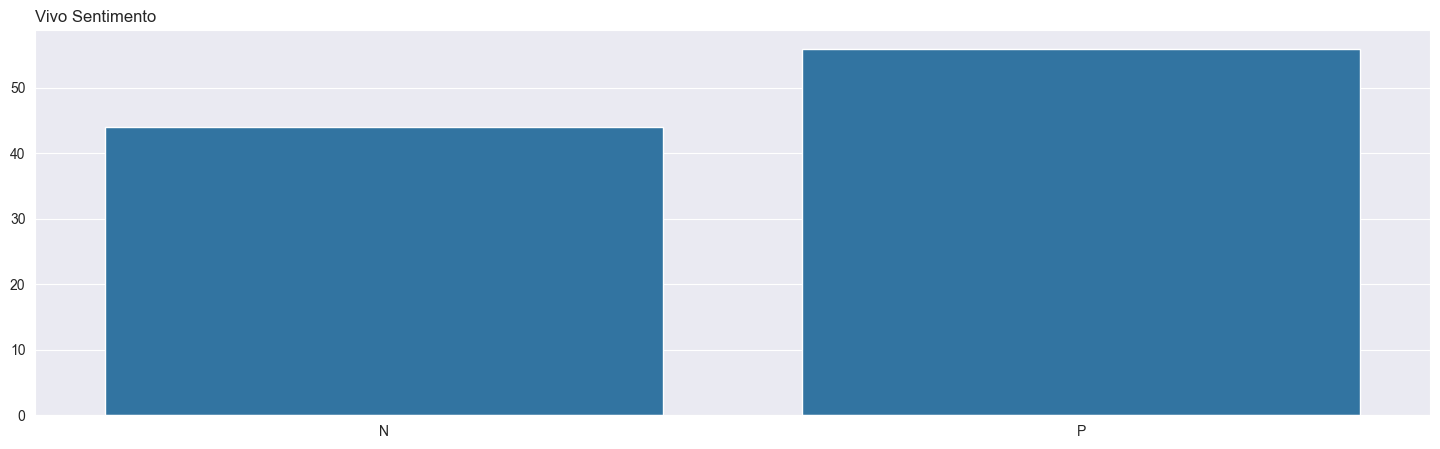

In [ ]:
grafico = df_resultado[df_resultado["app"] == "Claro"]
grafico = grafico["output"].value_counts().sort_index()

sns.set_style("darkgrid")
fig, axes = plt.subplots(figsize=(18, 5))

_ = sns.barplot(grafico)
_ = plt.title("Vivo Sentimento", loc="left")
_ = plt.xlabel("")
_ = plt.ylabel("")

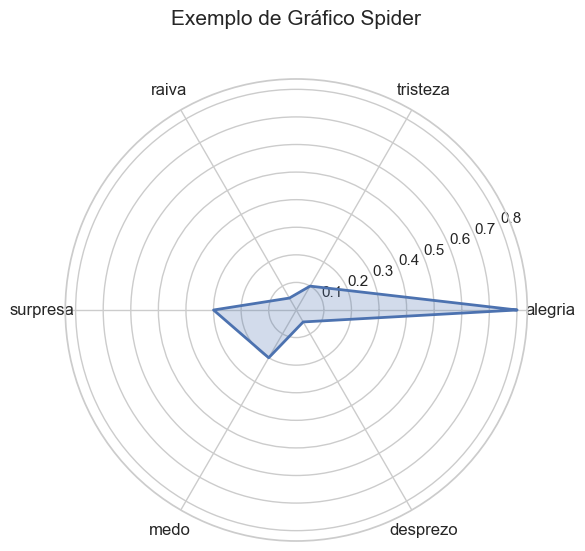

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Exemplo de dados: emoções e seus scores
data = {
    'emoções': ['alegria', 'tristeza', 'raiva', 'surpresa', 'medo', 'desprezo'],
    'score': [0.8, 0.1, 0.05, 0.3, 0.2, 0.05]
}

df = pd.DataFrame(data)

# Número de variáveis
categories = list(df['emoções'])
N = len(categories)

# Repetir o primeiro valor para fechar o gráfico
values = df['score'].tolist()
values += values[:1]

# Ângulos para cada eixo
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Estilo Seaborn
sns.set(style="whitegrid")

# Inicializa o radar
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Desenha a linha
ax.plot(angles, values, linewidth=2, linestyle='solid', color='b')
ax.fill(angles, values, 'b', alpha=0.25)

# Ajuste dos rótulos
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)

# Título
plt.title('Exemplo de Gráfico Spider', size=15, y=1.1)

plt.show()


In [63]:
import plotly.graph_objects as go

categories = ['alegria', 'tristeza', 'raiva', 'surpresa', 'medo']
values = [0.8, 0.1, 0.05, 0.3, 0.2]

fig = go.Figure(data=go.Scatterpolar(
    r=values + [values[0]],  # fechar a curva
    theta=categories + [categories[0]],
    fill='toself'
))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=False
)

fig.show()


# Classificação de Temas